In [1]:
import pandas as pd

price_df = []
demand_df = []

for year in range(2018, 2026):

    price_path  = fr'C:\Users\owner\Downloads\PUB_PriceHOEPPredispOR_{year}.csv'
    demand_path = fr'C:\Users\owner\Downloads\PUB_Demand_{year}.csv'


    df  = pd.read_csv(price_path,  skiprows=3)
    price_df.append(df)
    df = pd.read_csv(demand_path, skiprows =3)
    demand_df.append(df)

price_df = pd.concat(price_df, ignore_index= True)
demand_df = pd.concat(demand_df, ignore_index= True)

# Clean column names
price_df.columns = price_df.columns.str.strip()
demand_df.columns = demand_df.columns.str.strip()

# Build a timestamp
price_df['Date'] = pd.to_datetime(price_df['Date'], format= '%Y-%m-%d')
demand_df['Date'] = pd.to_datetime(demand_df['Date'], format='%Y-%m-%d')

price_df['timestamp'] = price_df['Date'] + pd.to_timedelta(price_df["Hour"]-1, unit = 'h')
demand_df['timestamp'] = demand_df['Date'] + pd.to_timedelta(demand_df['Hour'] - 1, unit='h')

demand_df = demand_df.drop(columns=["Date", "Hour"])  # keep only 1 version

demand_df = demand_df.rename(columns={"Ontario Demand": "Demand"})


# Merge on timestamp
combined_df = pd.merge(price_df, demand_df, on='timestamp', how='inner')

 # Forward fill 
combined_df['Hour 1 Predispatch'] = combined_df['Hour 1 Predispatch'].fillna(method='ffill')
    
combined_df['Hour 2 Predispatch'] = combined_df['Hour 2 Predispatch'].fillna(method='ffill')

combined_df['Hour 3 Predispatch'] = combined_df['Hour 3 Predispatch'].fillna(method='ffill')

# Quick check
display(combined_df.head())     # see first 5 rows
print(combined_df.info())       # check for nulls & types




C:\Users\owner\AppData\Local\Temp\ipykernel_11780\1093910698.py:40: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  combined_df['Hour 1 Predispatch'] = combined_df['Hour 1 Predispatch'].fillna(method='ffill')
C:\Users\owner\AppData\Local\Temp\ipykernel_11780\1093910698.py:42: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  combined_df['Hour 2 Predispatch'] = combined_df['Hour 2 Predispatch'].fillna(method='ffill')
C:\Users\owner\AppData\Local\Temp\ipykernel_11780\1093910698.py:44: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  combined_df['Hour 3 Predispatch'] = combined_df['Hour 3 Predispatch'].fillna(method='ffill')


,Date,Hour,HOEP,Hour 1 Predispatch,Hour 2 Predispatch,Hour 3 Predispatch,OR 10 Min Sync,OR 10 Min non-sync,OR 30 Min,timestamp,Market Demand,Demand
0,2018-01-01,1,51.29,40.62,35.50,40.32,0.20,0.20,0.19,2018-01-01 00:00:00,18974,16627
1,2018-01-01,2,43.59,40.93,40.57,30.22,0.20,0.20,0.20,2018-01-01 01:00:00,18447,16084
2,2018-01-01,3,93.60,49.84,45.30,40.20,0.25,0.25,0.22,2018-01-01 02:00:00,18453,15866
3,2018-01-01,4,54.78,55.60,40.04,45.30,0.20,0.20,0.20,2018-01-01 03:00:00,18662,15725
4,2018-01-01,5,14.35,40.04,34.80,47.47,0.20,0.20,0.20,2018-01-01 04:00:00,18060,15470


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64248 entries, 0 to 64247
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Date                64248 non-null  datetime64[ns]
 1   Hour                64248 non-null  int64         
 2   HOEP                64248 non-null  float64       
 3   Hour 1 Predispatch  64248 non-null  float64       
 4   Hour 2 Predispatch  64248 non-null  float64       
 5   Hour 3 Predispatch  64248 non-null  float64       
 6   OR 10 Min Sync      64248 non-null  float64       
 7   OR 10 Min non-sync  64248 non-null  float64       
 8   OR 30 Min           64248 non-null  float64       
 9   timestamp           64248 non-null  datetime64[ns]
 10  Market Demand       64248 non-null  int64         
 11  Demand              64248 non-null  int64         
dtypes: datetime64[ns](2), float64(7), int64(3)
memory usage: 5.9 MB
None


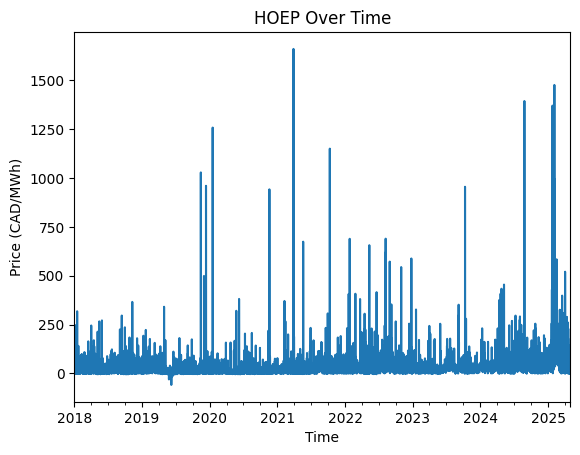

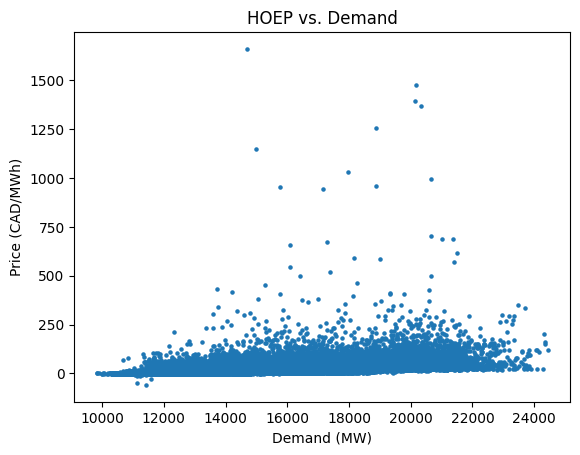

In [2]:
import matplotlib.pyplot as plt
# Price over time
plt.figure()
combined_df.set_index('timestamp')['HOEP'].plot(title='HOEP Over Time')
plt.xlabel('Time')
plt.ylabel('Price (CAD/MWh)')
plt.show()


# Demand vs. Price scatter
plt.figure()
plt.scatter(combined_df['Demand'], combined_df['HOEP'], s=5)
plt.title('HOEP vs. Demand')
plt.xlabel('Demand (MW)')
plt.ylabel('Price (CAD/MWh)')
plt.show()




In [3]:
import os

weather_path  = r'C:\Users\owner\Downloads\weather'

weather_files = [f for f in os.listdir(weather_path)]

dfs = []

for file in sorted(weather_files):
    file_path = os.path.join(weather_path, file)
    df = pd.read_csv(file_path)
    dfs.append(df)

weather_df = pd.concat(dfs, ignore_index = True)  

# Clean column names 
weather_df.columns = weather_df.columns.str.strip().str.replace('"', '')

# Rename to clean and parse timestamp
weather_df = weather_df.rename(columns={"Date/Time (LST)": "timestamp"})


# Parse datetime
weather_df["timestamp"] = pd.to_datetime(weather_df["timestamp"], errors="coerce")


# Keep relevant features only
cols_to_keep = {
    "timestamp": "timestamp",
    "Temp (°C)": "temp",
    "Rel Hum (%)": "humidity",
    "Wind Spd (km/h)": "wind_speed"
 }


weather_df = weather_df[list(cols_to_keep.keys())].rename(columns=cols_to_keep)
weather_df = weather_df.set_index("timestamp")


weather_df = weather_df.astype("float32")

# Sort and forward fill missing weather values
weather_df = weather_df.sort_index()
weather_df[["temp", "humidity", "wind_speed"]] = weather_df[["temp", "humidity", "wind_speed"]].ffill()



display(weather_df.head())     # see first 5 rows
print(weather_df.info())  








,temp,humidity,wind_speed
timestamp,,,
2018-01-01 00:00:00,-19.500000,67.0,9.0
2018-01-01 01:00:00,-21.700001,71.0,12.0
2018-01-01 02:00:00,-19.299999,73.0,9.0
2018-01-01 03:00:00,-20.299999,73.0,4.0
2018-01-01 04:00:00,-19.900000,75.0,4.0


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 64248 entries, 2018-01-01 00:00:00 to 2025-04-30 23:00:00
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   temp        64248 non-null  float32
 1   humidity    64248 non-null  float32
 2   wind_speed  64248 non-null  float32
dtypes: float32(3)
memory usage: 1.2 MB
None


In [5]:

merged_df = pd.merge(combined_df, weather_df, on='timestamp', how='inner')

print(merged_df.head())
print(merged_df.info())

        Date  Hour   HOEP  Hour 1 Predispatch  Hour 2 Predispatch  \
0 2018-01-01     1  51.29               40.62               35.50   
1 2018-01-01     2  43.59               40.93               40.57   
2 2018-01-01     3  93.60               49.84               45.30   
3 2018-01-01     4  54.78               55.60               40.04   
4 2018-01-01     5  14.35               40.04               34.80   

   Hour 3 Predispatch  OR 10 Min Sync  OR 10 Min non-sync  OR 30 Min  \
0               40.32            0.20                0.20       0.19   
1               30.22            0.20                0.20       0.20   
2               40.20            0.25                0.25       0.22   
3               45.30            0.20                0.20       0.20   
4               47.47            0.20                0.20       0.20   

            timestamp  Market Demand  Demand       temp  humidity  wind_speed  
0 2018-01-01 00:00:00          18974   16627 -19.500000      67.0       

In [ ]:
import numpy as np 
import holidays

# Create features

lags = [2,3,24]
roll_windows = [3,24]

df = merged_df.copy()
    
# Time features
df['hour_sin'] = np.sin(2 * np.pi * df['timestamp'].dt.hour / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['timestamp'].dt.hour / 24)
df['is_weekend'] = (df['timestamp'].dt.weekday >= 5).astype(int)
# Day of year 
df['day_of_year'] = df['timestamp'].dt.dayofyear
df['doy_sin'] = np.sin(2 * np.pi * df['day_of_year'] / 365)
df['doy_cos'] = np.cos(2 * np.pi * df['day_of_year'] / 365)
    
# Lagged features with no leakage
for k in lags:
    df[f'demand_lag_{k}']= df['Demand'].shift(k)
    df[f'temp_lag_{k}'] = df['temp'].shift(k)
    df[f'humidity_lag_{k}'] = df['humidity'].shift(k)
    df[f'wind_speed_lag_{k}'] = df['wind_speed'].shift(k)
    df[f'HOEP_lag_{k}'] = df['HOEP'].shift(k)
    df[f'OR_30_Min_lag_{k}'] = df['OR 30 Min'].shift(k)
    df[f'OR_10_Min_sync_lag{k}']  = df['OR 10 Min Sync'].shift(k)
    df[f'OR_10_Min_non-sync_lag{k}']  = df['OR 10 Min non-sync'].shift(k)

    
 # Rolling features
for win in roll_windows:
    df[f'demand_ma_{win}']     = df['demand_lag_2'].rolling(win).mean()
    df[f'temp_ma_{win}']       = df['temp_lag_2'].rolling(win).mean()
    df[f'humidity_ma_{win}']   = df['humidity_lag_2'].rolling(win).mean()
    df[f'wind_speed_ma_{win}'] = df['wind_speed_lag_2'].rolling(win).mean()
    df[f'HOEP_ma_{win}']       = df['HOEP_lag_2'].rolling(win).mean()

df = df.dropna()

print(df.head())
print("Earliest timestamp:", df["Date"].min())
print("Latest timestamp:  ", df["Date"].max())
print(df.shape)
print(df.isnull().sum())

print(df.info())

         Date  Hour   HOEP  Hour 1 Predispatch  Hour 2 Predispatch  \
25 2018-01-02     2  10.76               14.38               26.36   
26 2018-01-02     3  14.34               14.35               14.40   
27 2018-01-02     4   0.29               14.23               14.31   
28 2018-01-02     5   1.43               39.00               34.60   
29 2018-01-02     6  14.36               49.52               49.56   

    Hour 3 Predispatch  OR 10 Min Sync  OR 10 Min non-sync  OR 30 Min  \
25               39.47             0.2                 0.2       0.15   
26               14.37             0.2                 0.2       0.15   
27               14.32             0.2                 0.2       0.19   
28               14.37             0.2                 0.2       0.18   
29               50.00             0.2                 0.2       0.20   

             timestamp  ...   demand_ma_3  temp_ma_3  humidity_ma_3  \
25 2018-01-02 01:00:00  ...  17216.000000 -13.533333      64.333333  

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

features = ['Hour','Demand','dayofweek','month','Hour 1 Predispatch','OR 10 Min Sync','OR 30 Min']

X = df[features]
y = df['HOEP']

X_train, X_test = train_test_split(X, test_size=0.2, shuffle=False)
y_train, y_test = train_test_split(y, test_size=0.2, shuffle=False)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred= model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)

rmse = np.sqrt(mse)
print(f"MSE:  {mse:.2f}")
print(f"RMSE: {rmse:.2f} CAD/MWh")




In [ ]:
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

# Normalize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, shuffle=False)

# Build model
model = Sequential([
    Dense(32, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(16, activation='relu'),
    Dense(1)
])

# Compile
model.compile(optimizer=Adam(0.001), loss='mse')

# Train
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1)

# Predict
y_pred = model.predict(X_test).flatten()

# Evaluate
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f"RMSE: {rmse:.2f} CAD/MWh")






In [ ]:
df['Prev_HOEP'] = df['HOEP'].shift(1)
df = df.dropna()

features = ['Hour', 'Demand', 'dayofweek', 'month', 
            'Hour 1 Predispatch', 'OR 10 Min Sync', 'OR 30 Min', 
            'Prev_HOEP']

X = df[features]
y = df['HOEP']

X_train, X_test = train_test_split(X, test_size=0.2, shuffle=False)
y_train, y_test = train_test_split(y, test_size=0.2, shuffle=False)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred= model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)

rmse = np.sqrt(mse)
print(f"MSE:  {mse:.2f}")
print(f"RMSE: {rmse:.2f} CAD/MWh")


In [ ]:
# Normalize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, shuffle=False)

# Build model
model = Sequential([
    Dense(32, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(16, activation='relu'),
    Dense(1)
])

# Compile
model.compile(optimizer=Adam(0.001), loss='mse')

# Train
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1)

# Predict
y_pred = model.predict(X_test).flatten()

# Evaluate
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f"RMSE: {rmse:.2f} CAD/MWh")


In [ ]:
for lag in [2, 3]:
    df[f'HOEP_lag_{lag}'] = df['HOEP'].shift(lag)

for lag in [1,2,3]:
    df[f'Demand_lag_{lag}'] = df['Demand'].shift(lag)

features += [f'HOEP_lag_{lag}' for lag in [2, 3]]
features += [f'Demand_lag_{lag}' for lag in [1, 2, 3]]         

df['HOEP_ma_3'] = df['HOEP'].rolling(window=3).mean()
df['Demand_ma_3'] = df['Demand'].rolling(window=3).mean()


features += ['HOEP_ma_3', 'Demand_ma_3']

df = df.dropna()




In [ ]:
X= df[features]
y=df["HOEP"]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, shuffle=False)

# Build model
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1)
])

# Compile
model.compile(optimizer=Adam(0.001), loss='mse')

# Train
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1)

# Predict
y_pred = model.predict(X_test).flatten()

# Evaluate
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f"RMSE: {rmse:.2f} CAD/MWh")


In [ ]:
import os
import pandas as pd

downloads_folder = r'C:\Users\owner\Downloads'
years = range(2002, 2026)  # From 2002 to 2024

dfs = []

for year in years:
    filename = f'PUB_PriceHOEPPredispOR_{year}.csv'
    file_path = os.path.join(downloads_folder, filename)

    if os.path.exists(file_path):
        df = pd.read_csv(file_path, skiprows = 3)
        df['Year'] = year 
        dfs.append(df)

    else:
        print(f'File not found: {filename}')

combined_hoep_df = pd.concat(dfs, ignore_index=True)
print(f" Loaded {len(combined_hoep_df)} rows from {len(dfs)} files")        

            






In [ ]:
print(combined_hoep_df.columns)

In [ ]:
import os
import pandas as pd

downloads_folder = r'C:\Users\owner\Downloads'
years = range(2002, 2026)  # From 2002 to 2024
dfs = []

for year in years:
    filename = f'PUB_Demand_{year}.csv'
    file_path = os.path.join(downloads_folder, filename)

    if os.path.exists(file_path):
        df = pd.read_csv(file_path, skiprows = 3)
        df['Year'] = year 
        dfs.append(df)

    else:
        print(f'File not found: {filename}')

combined_demand_df = pd.concat(dfs, ignore_index=True)
print(f" Loaded {len(combined_demand_df)} rows from {len(dfs)} files")        

            

print(combined_demand_df.columns)




In [ ]:
import numpy as np
import pandas as pd
combined_hoep_df.columns = combined_hoep_df.columns.str.strip()
combined_demand_df.columns = combined_demand_df.columns.str.strip()

# Build timestamp
combined_hoep_df['Date'] = pd.to_datetime(combined_hoep_df['Date'], format= '%Y-%m-%d')
combined_demand_df['Date'] = pd.to_datetime(combined_demand_df['Date'], format= '%Y-%m-%d')

combined_hoep_df['timestamp'] = combined_hoep_df['Date'] + pd.to_timedelta(combined_hoep_df['Hour']-1, unit = 'h')
combined_demand_df['timestamp'] = combined_demand_df['Date'] + pd.to_timedelta(combined_demand_df['Hour']-1, unit = 'h')

display(combined_demand_df.head()) 
display(combined_hoep_df.head())

combined_hoep_clean = combined_hoep_df[['timestamp','HOEP','Hour 1 Predispatch','OR 10 Min Sync', 'OR 30 Min','Hour']].copy()
combined_demand_clean = combined_demand_df[['timestamp','Ontario Demand']].copy()

# Encode Hour as sin/cos
combined_hoep_clean['hour_sin'] = np.sin(2* np.pi * (combined_hoep_clean['Hour']-1)/24)
combined_hoep_clean['hour_cos'] = np.cos(2 * np.pi * (combined_hoep_clean['Hour'] - 1) / 24)
combined_hoep_clean.drop(columns='Hour', inplace=True)

merged_df = pd.merge(combined_hoep_clean, combined_demand_clean, on= 'timestamp', how= 'inner')

display(merged_df.head())

In [ ]:
# Columns to clean
columns_to_clean = ['HOEP', 'Ontario Demand', 'Hour 1 Predispatch', 'OR 10 Min Sync', 'OR 30 Min']

for col in columns_to_clean:
    merged_df[col] = (
        merged_df[col]
        .astype(str)                # just in case
        .str.replace(',', '')       # remove commas
        .astype(float)              # convert to float
    )

features = []

# Lag features
for lag in [1, 2, 3]:
    merged_df[f'HOEP_lag_{lag}'] = merged_df['HOEP'].shift(lag)
    merged_df[f'Demand_lag_{lag}'] = merged_df['Ontario Demand'].shift(lag)
    features.append(f'HOEP_lag_{lag}')
    features.append(f'Demand_lag_{lag}')

# Rolling means
merged_df['HOEP_ma_3'] = merged_df['HOEP'].rolling(window=3).mean()
merged_df['Demand_ma_3'] = merged_df['Ontario Demand'].rolling(window=3).mean()
features += ['HOEP_ma_3', 'Demand_ma_3']

# Add engineered time features + known inputs
features += [
    'Hour 1 Predispatch',
    'OR 10 Min Sync',
    'OR 30 Min',
    'hour_sin',
    'hour_cos'
]

# Final cleanup
merged_df = merged_df.dropna().reset_index(drop=True)


In [ ]:
display(merged_df.head())
print(merged_df['timestamp'].min(), merged_df['timestamp'].max())
print(len(merged_df))

In [ ]:
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X= merged_df[features]
y=merged_df["HOEP"]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, shuffle=False)

# Build model
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1)
])

# Compile
model.compile(optimizer=Adam(0.001), loss='mse')

# Train
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1)

# Predict
y_pred = model.predict(X_test).flatten()

# Evaluate
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f"RMSE: {rmse:.2f} CAD/MWh")



In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label='Actual HOEP', linewidth=2)
plt.plot(y_pred, label='Predicted HOEP', linewidth=2)
plt.title('Model Prediction vs. Actual (HOEP)')
plt.xlabel('Time Step')
plt.ylabel('HOEP (CAD/MWh)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
